# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [4]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

# See this list for possible experiments / datastores to use:
# https://access-om3-configs.access-hive.org.au/Experiments/

### USER EDIT start
#esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
esm_file = "/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/x77/aek156/access-om3-paper-figs/


In [5]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [6]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35981 instead
  warnings.warn(


/proxy/35981/status


In [7]:
IAF = esm_file.find('iaf') > 0
IAF

True

### Open the intake-esm datastore

In [8]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [9]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [10]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
GM_sfn_y,Parameterized Meridional Overturning Streamfun...,,rho2_i:point yq:point xh:mean time: mean,m3 s-1
KE,Layer kinetic energy per unit mass,,area:mean z_l:mean yh:mean xh:mean time: mean,m2 s-2
Kd_Itidal_Work,Work done by Internal Tide Diapycnal Mixing,,area:mean z_l:mean yh:mean xh:mean time: mean,W m-2
Kd_ePBL,ePBL diapycnal diffusivity at interfaces,,area:mean zi:point yh:mean xh:mean time: mean,m2 s-1
Kd_interface,Total diapycnal diffusivity at interfaces,,area:mean zi:point yh:mean xh:mean time: mean,m2 s-1
...,...,...,...,...
zi,"Interface pseudo-depth, -z*",,,meter
zos,Sea surface height above geoid,sea_surface_height_above_geoid,area:mean yh:mean xh:mean time: mean,m
zos_max,Sea surface height above geoid,sea_surface_height_above_geoid,area:mean yh:mean xh:mean time: max,m


### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [11]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [14]:
zos

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 792, yh: 1142, xh: 1440)
Coordinates:
  * xh       (xh) float64 12kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
  * time     (time) object 6kB 1958-01-16 12:00:00 ... 2023-12-16 12:00:00
Data variables:
    zos      (time, yh, xh) float32 5GB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
Attributes: (12/15)
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['zos']
    intake_esm_attrs:file_id:                 ocean.1mon.nv:2.xh:1440.yh:1152
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,sea_surface_height_abov...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,area:mean yh:mean xh:me...
    intake_esm_attrs:variable_units:          days,days since 1900-01-01 00:0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon.nv:2.xh:1440.yh:1152

In [12]:
if esm_file.find('25km-iaf-test-for-AK-expt-7df5ef4c') > 0:
    # omit latitudes with grid bug in this run https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
    zos = zos.isel(yh=slice(10, None))  # choose appropriate y coordinate name here

In [13]:
if IAF:
    zos = zos.convert_calendar("proleptic_gregorian", use_cftime=True)

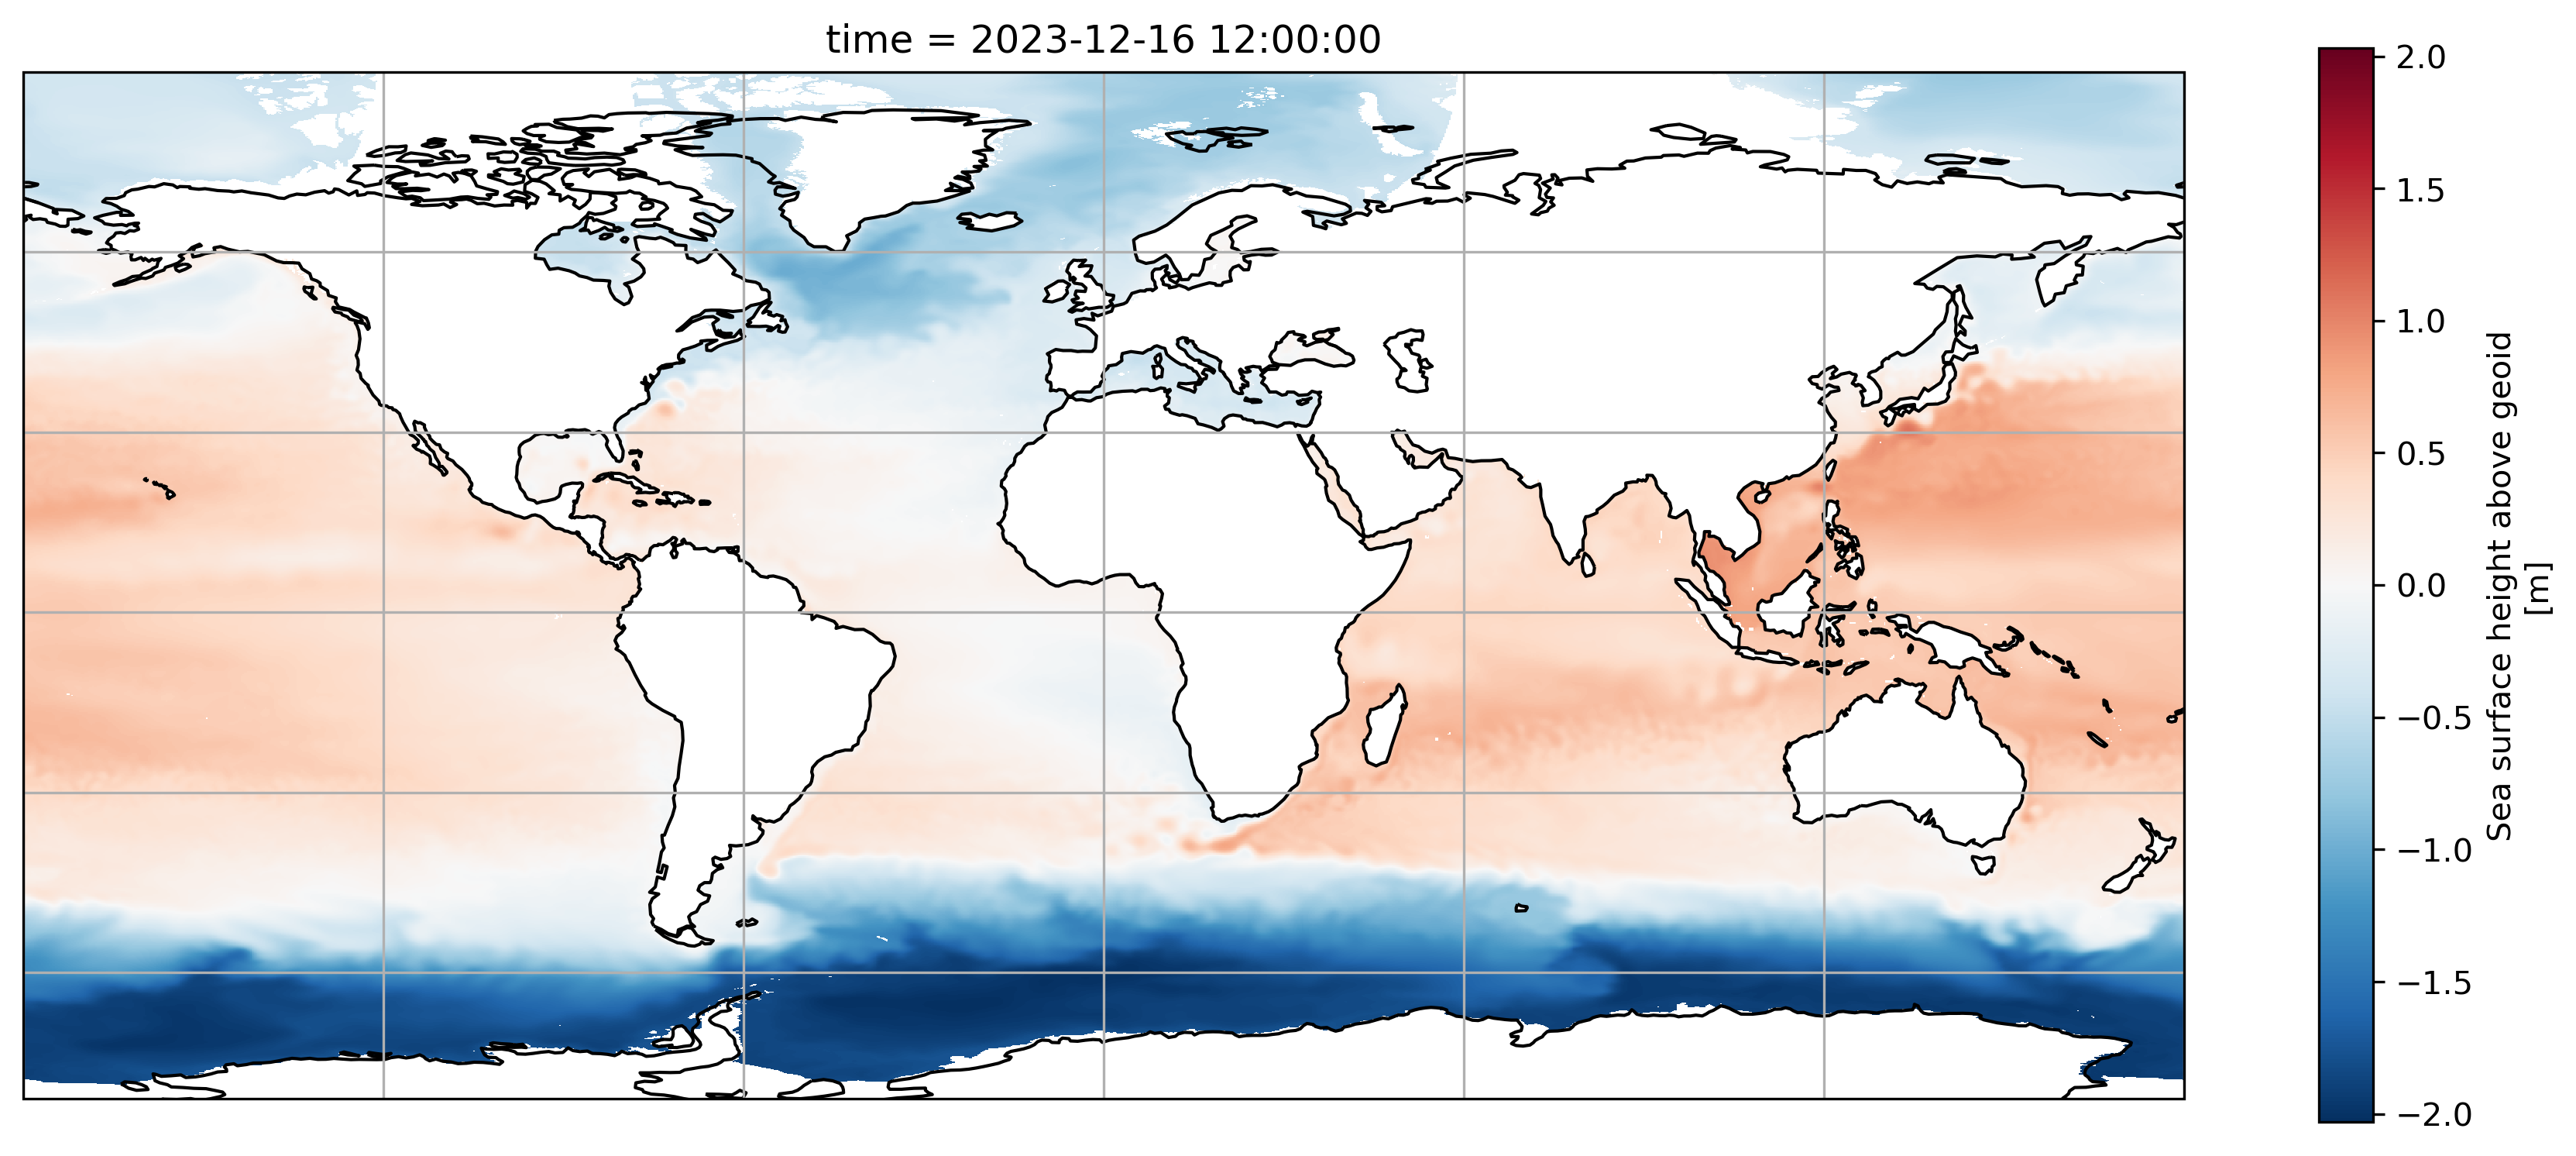

In [15]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

pme=zos["zos"].isel(time=-1).convert_calendar("proleptic_gregorian", use_cftime=True)
pme.plot(ax=ax)
#zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [16]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


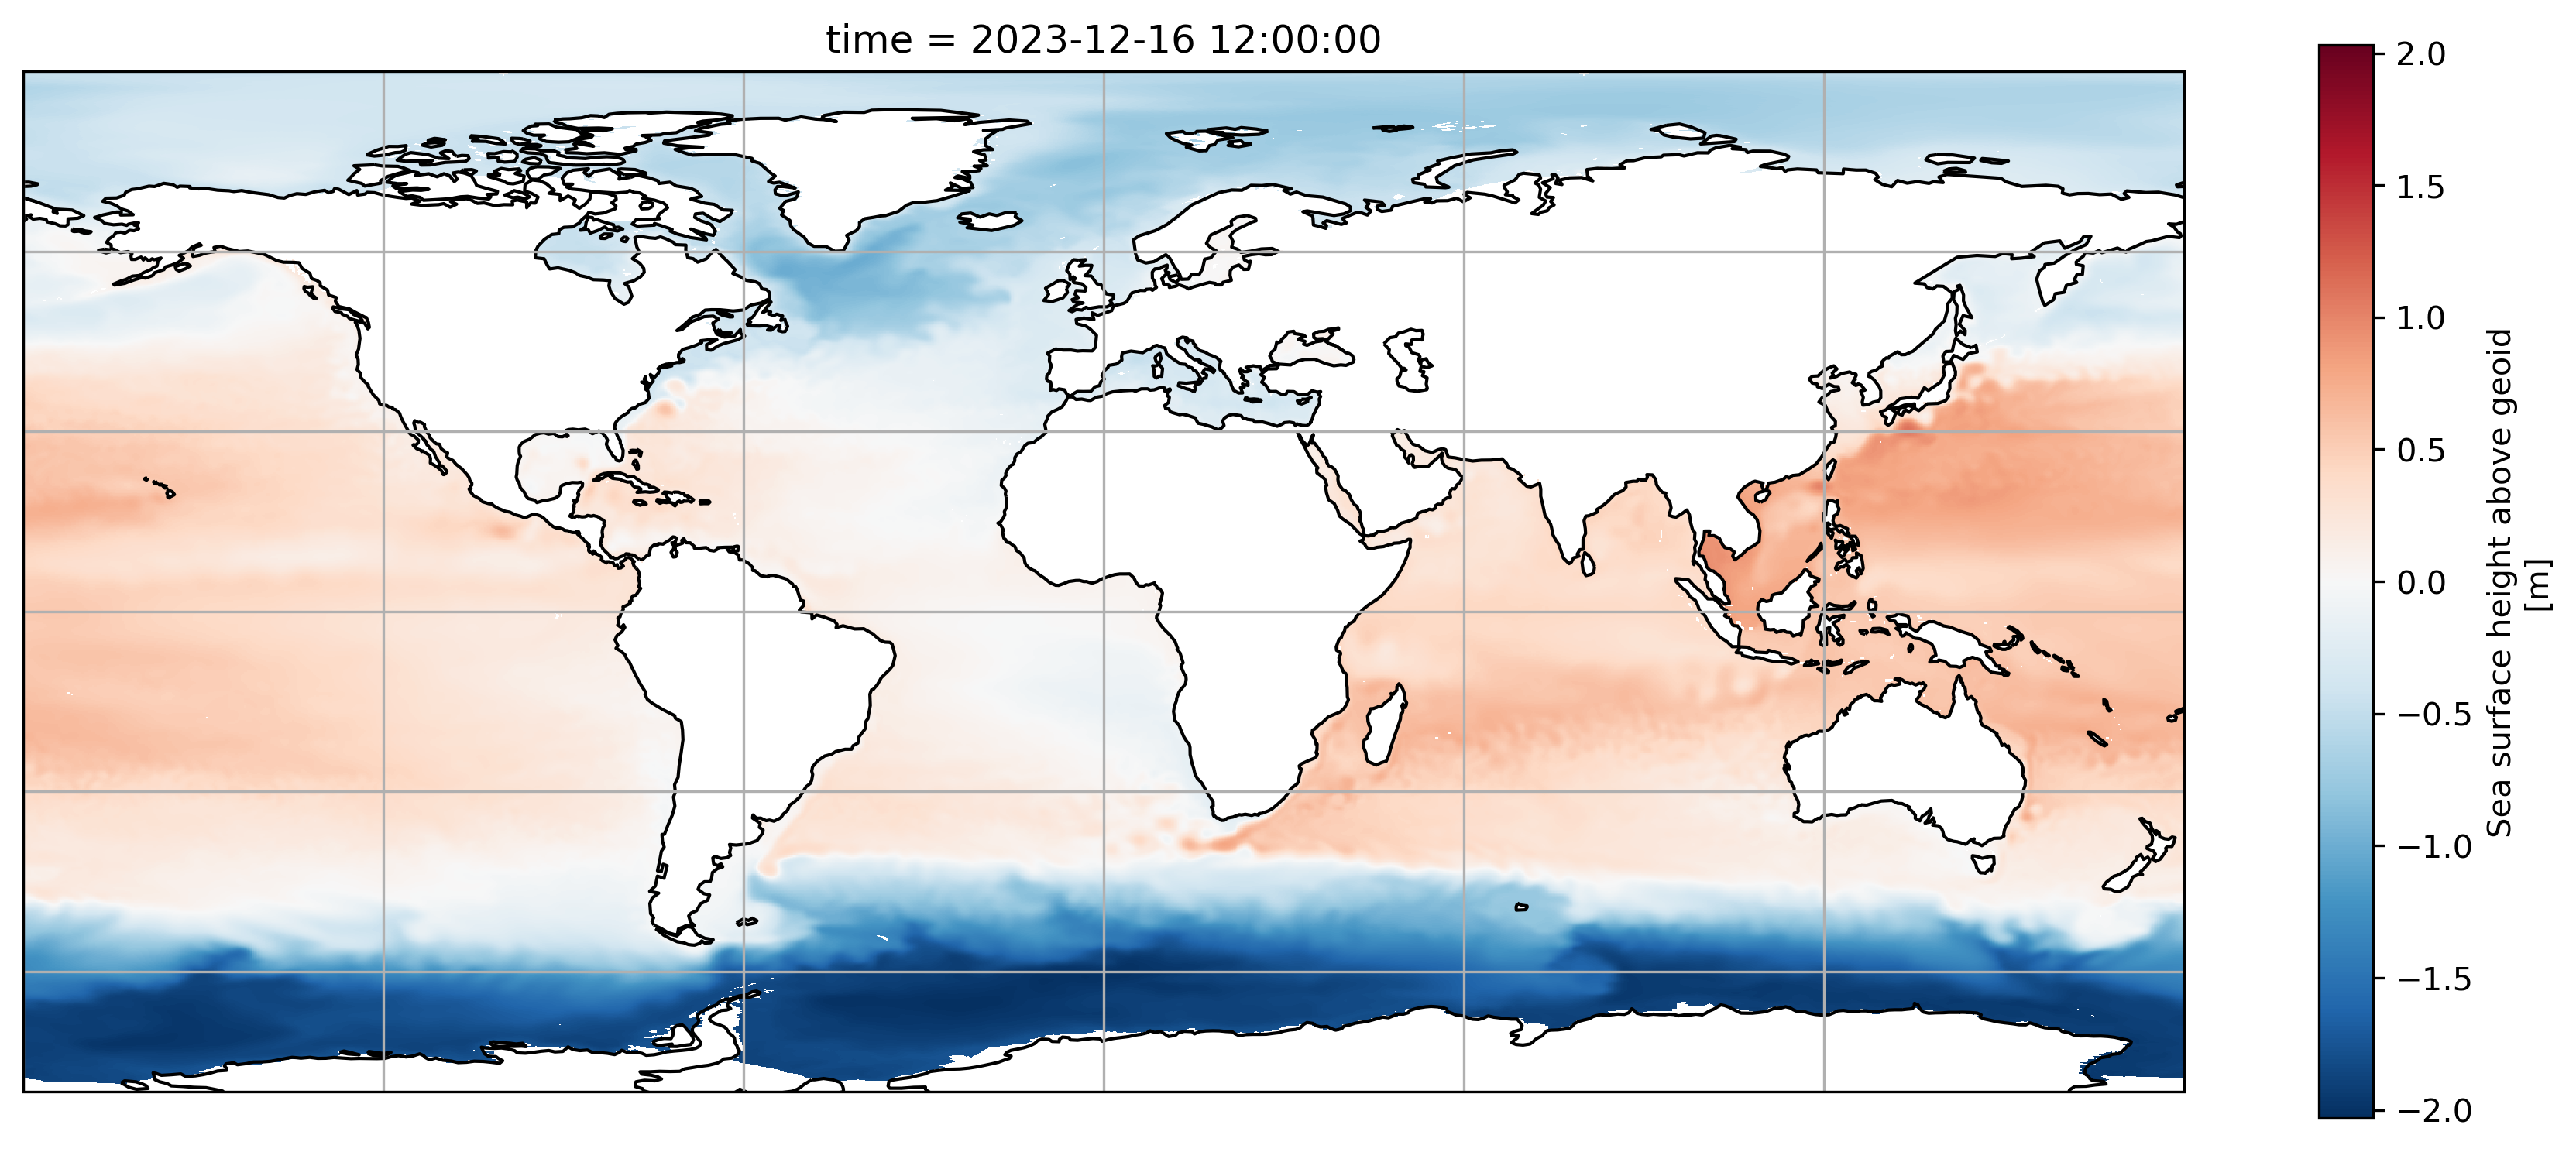

In [17]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()